# Analisis de sentimiento

## Librerías necesarias

In [1]:
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import matplotlib.pyplot as plt

## Cargamos datos

Vamos a utilizar para le análisis de sentimientos las reviews de Amazón de los siguientes temas: 
    Automotive
    Baby
    Digital music
    Musical instruments
    Office products
    Pet supplies

Para el análisis de sentimiento vamos a considerar solo las menores de tres para sentimiento negativo y las mayores de tres para sentimiento positivo.
n una primera carga comprobé que los ficheros estaban muy desvalanceados, s decir, que había muchos con sentimiento positivo y pocos con sentimiento negativo. Para balancear la carga se me ocurrió cargar todos los de sentimiento negativos y luego cargar tantos positivos como negativos hay de cada tema elegido.

In [2]:
import glob
# Primero especificamos un patrón del archivo y lo pasamos como parámetro en la función glob
json_files = glob.glob('datos/*.json')
# Mostrar el archivo csv_files, el cual es una lista de nombres
list_data = []
  
# Escribimos un loop que irá a través de cada uno de los nombres de archivo a través de globbing y el resultado final será la lista dataframes

for filename in json_files:
    data = pd.read_json(filename, lines = True)
    df_neg = data[data['overall']<=2]
    list_data.append(df_neg)
    list_data.append(data[data['overall']>=4][:df_neg.shape[0]])
    #list_data.append(data[:5000])

#Para chequear que todo está bien, mostramos la list_data por consola
list_data
 
df=pd.concat(list_data,ignore_index=True)

Vemos los datos cargados, la cantidad de ellos con los que vamos hacer el análisis de sentimientos.

In [3]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3LYC4BXRDE5RZ,B00008RW9U,Chi Car Guy,"[3, 10]",I would not buy this product again. It does wh...,2,Does what it is supposed to,1248134400,"07 21, 2009"
1,A3FP9141P7DHT6,B0000AXPDU,Amazon Customer,"[0, 0]",Bought this for my spare tire on my utility tr...,2,You get what you pay for.,1369872000,"05 30, 2013"
2,A204K1OFE8OB9Y,B0000AXRH5,Winter,"[4, 7]",The size measurements provided are a bit disin...,1,too small and too short to add any benefit,1323129600,"12 6, 2011"
3,A1HI4VM5Q4LUET,B0000AXY62,Bongo,"[0, 0]",I am using this on a Curt receiver and the len...,2,Didn't hold up very well.,1272585600,"04 30, 2010"
4,A1P3RTQKM8BRBL,B0000AY60S,Ed D,"[14, 16]",I am a car RV detail guy. My car and RV must b...,2,This wax takes detailing to a higher level AT ...,1369872000,"05 30, 2013"


In [4]:
df.shape

(89878, 9)

In [5]:
df['overall'].unique()
df['overall'].value_counts()

5    34363
2    23692
1    21247
4    10576
Name: overall, dtype: int64

Borramos las columnas que no vamos a utilizar

In [ ]:
columnas_borrar = [
    'reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 
    'reviewTime'
]

df.drop(columnas_borrar, axis=1, inplace=True)

Etiquetamos lo que anteriormente he comentado, los menos de 3 negativos y los mayores de tres positivos.

In [8]:
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 'neg'
    else:
         return 'pos'
    

In [9]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

Vemos que nuestro datatset tiene tantas valoraciones positivas como de negativas.

In [10]:
df['sentiment_label'].unique()
df['sentiment_label'].value_counts()

pos    44939
neg    44939
Name: sentiment_label, dtype: int64

In [11]:
df.drop(['overall'], axis=1, inplace=True)

Realizamos un poco de prepocesado de los reviews. Ponemos todo en minúsculas, eliminamos carateres extraños y eliminamos números.

In [12]:
import re
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df
data_clean = clean_text(df, 'reviewText', 'reviewText_clean')
data_clean.head()

,reviewText,sentiment_label,reviewText_clean
0,I would not buy this product again. It does wh...,neg,i would not buy this product again it does wh...
1,Bought this for my spare tire on my utility tr...,neg,bought this for my spare tire on my utility tr...
2,The size measurements provided are a bit disin...,neg,the size measurements provided are a bit disin...
3,I am using this on a Curt receiver and the len...,neg,i am using this on a curt receiver and the len...
4,I am a car RV detail guy. My car and RV must b...,neg,i am a car rv detail guy my car and rv must b...


Aquí en este análisis no voy a eliminar stop words, peor lo que si voy hacer es lematizar.

In [13]:
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [14]:
data_clean['reviewText_clean'] = data_clean['reviewText_clean'].apply(lambda x: ' '.join([get_lemma2(word) for word in x.split() ]))
data_clean.head()

,reviewText,sentiment_label,reviewText_clean
0,I would not buy this product again. It does wh...,neg,i would not buy this product again it doe what...
1,Bought this for my spare tire on my utility tr...,neg,bought this for my spare tire on my utility tr...
2,The size measurements provided are a bit disin...,neg,the size measurement provided are a bit dising...
3,I am using this on a Curt receiver and the len...,neg,i am using this on a curt receiver and the len...
4,I am a car RV detail guy. My car and RV must b...,neg,i am a car rv detail guy my car and rv must be...


## Separamos en conjunto de train y test

Realizamos conjuntos que esten balanceados, para eso utilizamos la propiedad **stratify**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText_clean'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=df['sentiment_label']
)

Vemos que los conjuntos realizados de train y test hay igual cantidad de positivos como de negativos.

In [16]:
y_train.unique()
y_train.value_counts()

pos    33704
neg    33704
Name: sentiment_label, dtype: int64

In [17]:
y_test.unique()
y_test.value_counts()

neg    11235
pos    11235
Name: sentiment_label, dtype: int64

## Extracción de características

Utiliamos TF-IDF vectorizer. En esta primera extracción usamos un máximo de caraterísticas de 2500, eliminamos todas las palabras que no te salgan 5 veces y solo tokens sin bigramas y trigramas.

In [18]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    ngram_range=(1,1)
)
cv.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=2500,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [19]:
print(list(cv.vocabulary_.items())[:20])

[('never', 1410), ('how', 1037), ('much', 1376), ('fun', 865), ('baby', 148), ('could', 499), ('have', 974), ('in', 1064), ('play', 1581), ('mat', 1285), ('our', 1489), ('son', 2001), ('used', 2334), ('this', 2208), ('for', 837), ('month', 1356), ('it', 1105), ('wa', 2365), ('to', 2239), ('watch', 2393)]


In [20]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [23]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 35321
Sentiment: pos
Review: great for my medela baby bottle this brush clean them well and easy to use with the bottle i highly recommend


In [ ]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 5
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Vemos que aparecen palabras como love,great, perfect, disappointed, return, best en el Top 15 de chi-squared

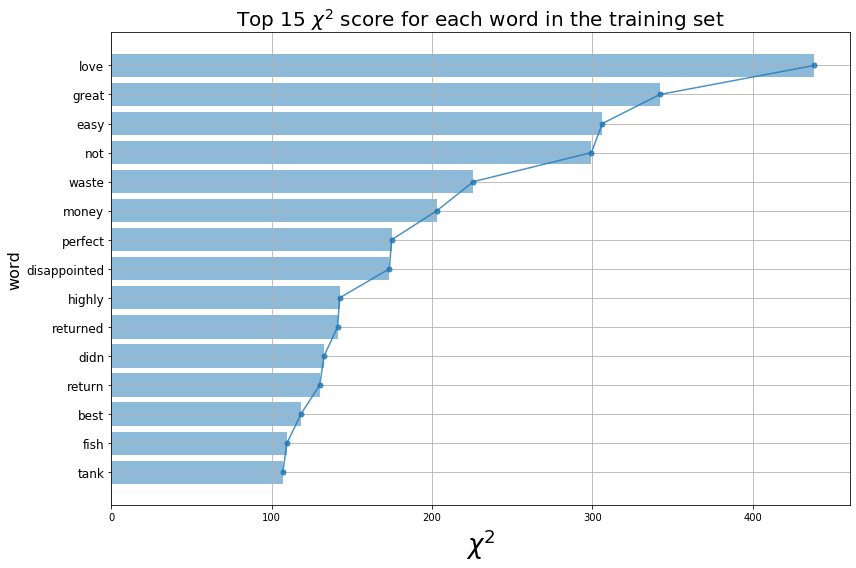

In [25]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

Creamos una regresión logística y entrenamos para diferentes paraámetros.

In [26]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.8146417445482866
Accuracy for C=0.05: 0.8434801958166445
Accuracy for C=0.25: 0.8654650645304851
Accuracy for C=0.5: 0.8706720071206052
Accuracy for C=1: 0.8751223854027592
Accuracy for C=10: 0.87543391188251
Accuracy for C=100: 0.8738762794837561
Accuracy for C=1000: 0.873787271918113
Accuracy for C=10000: 0.87369826435247


In [27]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[9821 1414]
 [1424 9811]]

Classification report:
              precision    recall  f1-score   support

         neg       0.87      0.87      0.87     11235
         pos       0.87      0.87      0.87     11235

    accuracy                           0.87     22470
   macro avg       0.87      0.87      0.87     22470
weighted avg       0.87      0.87      0.87     22470

Accuracy score:0.87369826435247


Vemos como hemos llegado a una Accuracy del 87% para negativas como para positivas.

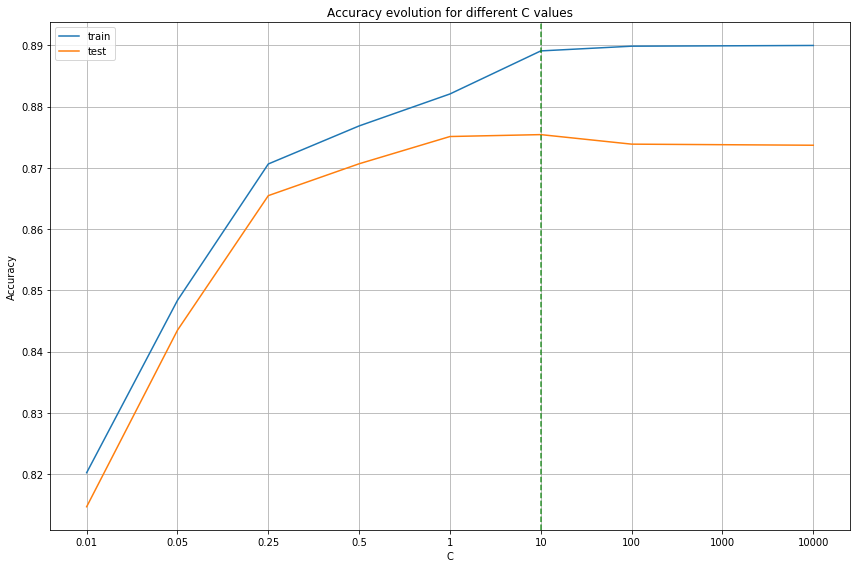

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Vamos si mejora el modelo metiendo bigramas.

In [61]:
cv1 = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    ngram_range=(1, 2)
)
cv1.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=2500,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [62]:
print(list(cv1.vocabulary_.items())[:20])

[('never', 1299), ('how', 871), ('much', 1257), ('fun', 711), ('baby', 177), ('could', 435), ('have', 799), ('in', 898), ('play', 1512), ('mat', 1195), ('our', 1443), ('son', 1783), ('used', 2279), ('this', 2097), ('for', 661), ('month', 1237), ('it', 973), ('wa', 2312), ('to', 2145), ('watch', 2340)]


In [63]:
X_train_ = cv1.transform(X_train)
X_test_ = cv1.transform(X_test)

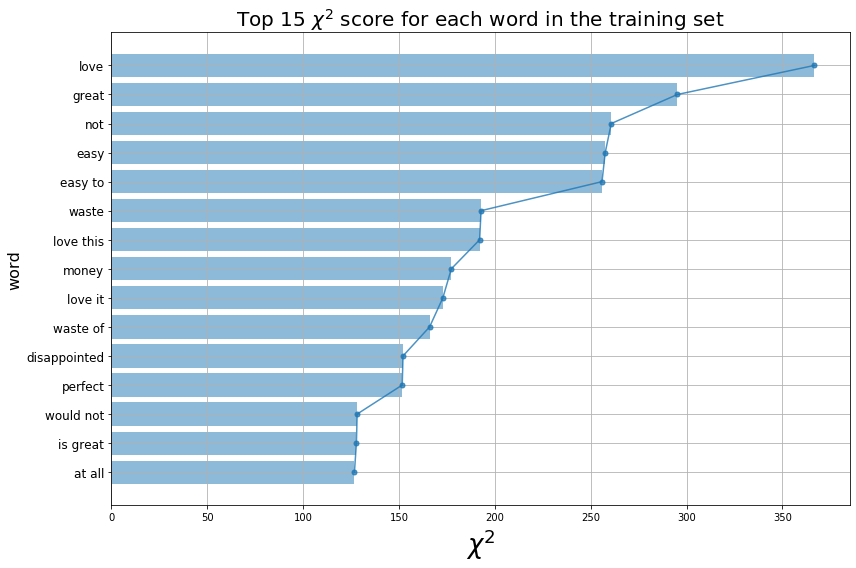

In [64]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv1.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

In [65]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.8183355585224744
Accuracy for C=0.05: 0.8496662216288384
Accuracy for C=0.25: 0.8709390298175345
Accuracy for C=0.5: 0.8758789497107254
Accuracy for C=1: 0.8773920783266578
Accuracy for C=10: 0.8775255896751224
Accuracy for C=100: 0.87716955941255
Accuracy for C=1000: 0.8769025367156208
Accuracy for C=10000: 0.8767245215843347


Vemos el resultado no mejora de manera relevante metiendo bigramas

In [66]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[9853 1382]
 [1388 9847]]

Classification report:
              precision    recall  f1-score   support

         neg       0.88      0.88      0.88     11235
         pos       0.88      0.88      0.88     11235

    accuracy                           0.88     22470
   macro avg       0.88      0.88      0.88     22470
weighted avg       0.88      0.88      0.88     22470

Accuracy score:0.8767245215843347


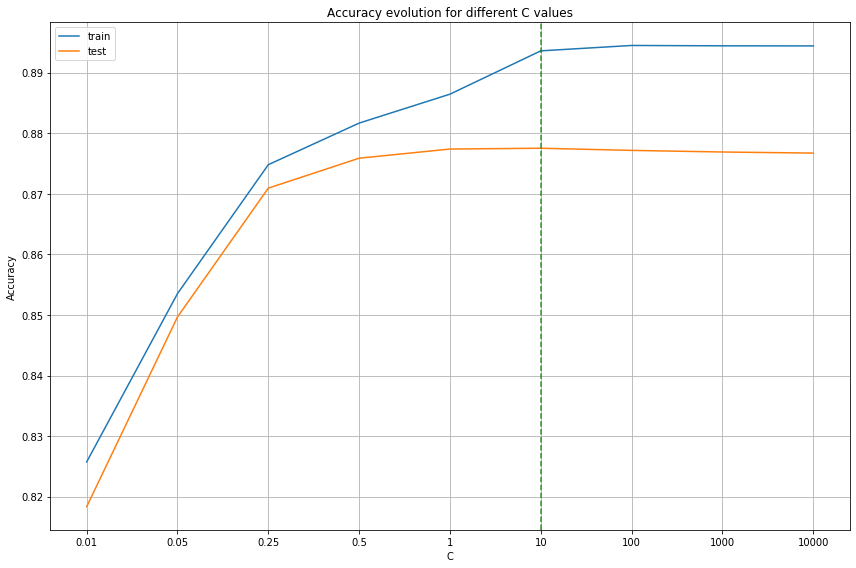

In [67]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

En los siguientes modelos hemos introducido quitar stop-words, el siguiente modelo con bigramas y el ultimo modelo solo con tokens.

Los modelos eliminando stop words no mejoran los modelos anteriores.

In [68]:
cv2 = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    ngram_range=(1,2),
    stop_words='english'
)
cv2.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=2500,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [69]:
print(list(cv2.vocabulary_.items())[:20])

[('fun', 857), ('baby', 122), ('play', 1569), ('mat', 1307), ('son', 1986), ('used', 2300), ('month', 1376), ('wa', 2337), ('watch', 2401), ('grow', 943), ('love', 1265), ('laying', 1173), ('looking', 1258), ('seeing', 1864), ('picture', 1554), ('grew', 935), ('realized', 1721), ('sound', 2003), ('turned', 2273), ('toy', 2236)]


In [70]:
X_train_ = cv2.transform(X_train)
X_test_ = cv2.transform(X_test)

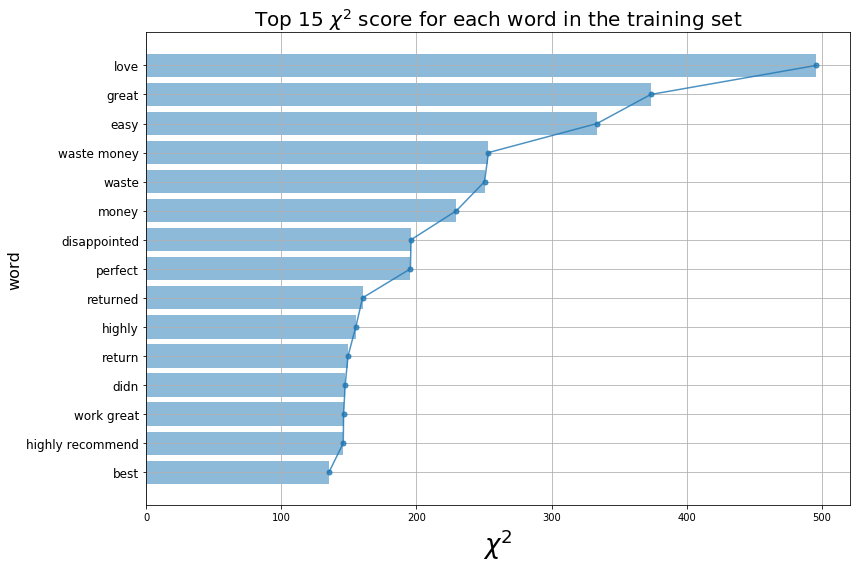

In [71]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv2.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

In [72]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.811704494882065
Accuracy for C=0.05: 0.8373386737872719
Accuracy for C=0.25: 0.8573208722741433
Accuracy for C=0.5: 0.8609701824655096
Accuracy for C=1: 0.8629283489096573
Accuracy for C=10: 0.8633733867378727
Accuracy for C=100: 0.8624388072986204
Accuracy for C=1000: 0.8623943035157988


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy for C=10000: 0.8623052959501558


In [73]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[9636 1599]
 [1495 9740]]

Classification report:
              precision    recall  f1-score   support

         neg       0.87      0.86      0.86     11235
         pos       0.86      0.87      0.86     11235

    accuracy                           0.86     22470
   macro avg       0.86      0.86      0.86     22470
weighted avg       0.86      0.86      0.86     22470

Accuracy score:0.8623052959501558


In [74]:
cv3 = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    ngram_range=(1,1),
    stop_words='english'
)
cv3.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=2500,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [75]:
print(list(cv3.vocabulary_.items())[:20])

[('fun', 863), ('baby', 132), ('play', 1584), ('mat', 1305), ('son', 2022), ('used', 2347), ('month', 1378), ('wa', 2378), ('watch', 2407), ('grow', 938), ('love', 1263), ('laying', 1183), ('looking', 1254), ('seeing', 1890), ('picture', 1566), ('grew', 930), ('realized', 1733), ('sound', 2033), ('turned', 2315), ('hitting', 1022)]


In [76]:
X_train_ = cv3.transform(X_train)
X_test_ = cv3.transform(X_test)

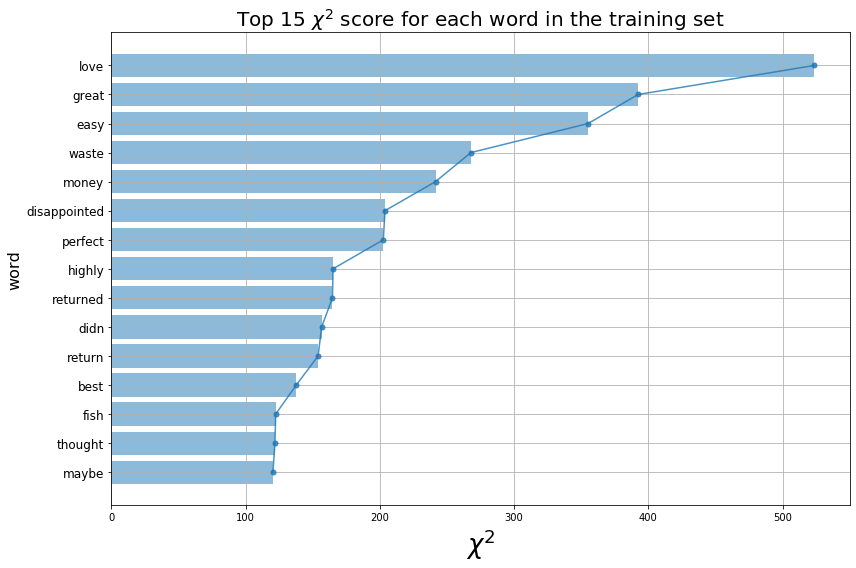

In [77]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv3.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

In [78]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.8091677792612372
Accuracy for C=0.05: 0.8341789052069426
Accuracy for C=0.25: 0.8512238540275924
Accuracy for C=0.5: 0.8552291944815309
Accuracy for C=1: 0.8581219403649311
Accuracy for C=10: 0.8589230084557188
Accuracy for C=100: 0.8580329327992879
Accuracy for C=1000: 0.8580329327992879
Accuracy for C=10000: 0.8580774365821094


In [79]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[9607 1628]
 [1561 9674]]

Classification report:
              precision    recall  f1-score   support

         neg       0.86      0.86      0.86     11235
         pos       0.86      0.86      0.86     11235

    accuracy                           0.86     22470
   macro avg       0.86      0.86      0.86     22470
weighted avg       0.86      0.86      0.86     22470

Accuracy score:0.8580774365821094
